# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий

В качестве датасета для данной лаборатороной работы я выбрал классификацию по обнаружению [огня](https://www.kaggle.com/datasets/phylake1337/fire-dataset) на фотографии.

Обучение модели для определения огня на изображении может повысить эффективность систем противопожарной безопасности. Например, она может быть использована в камерах видеонаблюдения.


Используемые метрики Accuracy, Precision, Recall, F1 позволяют оценивать точность модели и количество ложных срабатываний.

Подключим необходимые библиотеки в том числе и torchvision для обучения модели

In [16]:
import os
import shutil
import random
import copy
import time
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import (
    resnet18, ResNet18_Weights,
    densenet121, DenseNet121_Weights,
    vit_b_16, ViT_B_16_Weights
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 2. Создание бейзлайна и оценка качества
## 2.a. Обучение моделей (CNN и ViT) из torchvision на выбранном наборе данных

In [9]:
! python3 -m pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [15]:
import kagglehub

path = kagglehub.dataset_download("phylake1337/fire-dataset")

print("Path to dataset files:", path)

100%|██████████| 387M/387M [00:31<00:00, 13.0MB/s] 

Extracting files...


Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/phylake1337/fire-dataset/versions/1


In [27]:
base_dir = 'fire/'
categories = ['fire_images', 'non_fire_images']
subsets = ['train', 'val', 'test']

for subset in subsets:
    for category in categories:
        path = os.path.join(base_dir, subset, category)
        os.makedirs(path, exist_ok=True)

In [28]:
def split_data(source_dir, base_dir, train_split=0.7, val_split=0.15):
    for category in categories:
        files = os.listdir(os.path.join(source_dir, category))
        random.shuffle(files)
        
        train_index = int(train_split * len(files))
        val_index = int((train_split + val_split) * len(files))

        train_files = files[:train_index]
        val_files = files[train_index:val_index]
        test_files = files[val_index:]

        for file in train_files:
            src = os.path.join(source_dir, category, file)
            dst = os.path.join(base_dir, 'train', category, file)
            shutil.copy2(src, dst)

        for file in val_files:
            src = os.path.join(source_dir, category, file)
            dst = os.path.join(base_dir, 'val', category, file)
            shutil.copy2(src, dst)

        for file in test_files:
            src = os.path.join(source_dir, category, file)
            dst = os.path.join(base_dir, 'test', category, file)
            shutil.copy2(src, dst)

path = "/home/jupyter/.cache/kagglehub/datasets/phylake1337/fire-dataset/versions/1/fire_dataset"
split_data(path, "/home/jupyter/datasphere/project/multi/fire")

In [29]:
path = "/home/jupyter/datasphere/project/multi/fire"

train_dir = os.path.join(path, 'train')
val_dir   = os.path.join(path, 'val')
test_dir  = os.path.join(path, 'test')

Проведем нормализацию изображений и приведем их к нужному размеру

In [30]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [31]:
train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds   = ImageFolder(val_dir,   transform=val_tfms)
test_ds  = ImageFolder(test_dir,  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

Функции для обучения модели по эпохам и вычисления метрик

In [108]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, data_loader, optim, loss_fn):
    model.train()
    total_loss = 0.0

    for inputs, targets in tqdm(data_loader, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optim.zero_grad()
        
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        
        loss.backward()
        optim.step()
        
        total_loss += loss.item() * inputs.size(0)

    average_loss = total_loss / len(data_loader.dataset)
    return average_loss

@torch.no_grad()
def evaluate_model(model, data_loader):
    model.eval()
    true_labels, predicted_labels = [], []

    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        
        logits = model(inputs)
        predicted_labels.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(targets.numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')

    return accuracy, precision, recall, f1


Настраиваем и выполняем дообучение двух моделей, ResNet18 и ViT_B_16, сохраняя их лучшие результаты по метрике точности на валидационном наборе.
Устанавливаем функцию потерь и оптимизатор Adam.
Выполняем цикл дообучения, в котором вычисляем потери на тренировочном наборе и оцениваем модель по валидационному набору, вычисляя метрики.
Сохраняем лучшую модель на основе точности и загружаем ее для финальной оценки на тестовом наборе.

In [120]:
def train_model(model, train_loader, val_loader, lr=1e-4, epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)

        acc, prec, rec, f1 = evaluate_model(model, val_loader)
        print(f"Epoch {epoch}/{epochs} — "
              f"Train Loss: {train_loss:.4f}  "
              f"Val Acc: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_weights = model.state_dict()

    model.load_state_dict(best_weights)
    return model

evaluation_results = {}

resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
trained_resnet_model = train_model(resnet_model, train_loader, val_loader, lr=1e-4, epochs=6)

vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 2)
trained_vit_model = train_model(vit_model, train_loader, val_loader, lr=1e-4, epochs=6)


Epoch 1/6 — Train Loss: 0.3091  Val Acc: 0.9867, Precision: 0.9730, Recall: 0.9730, F1: 0.9730


Epoch 2/6 — Train Loss: 0.0562  Val Acc: 0.9867, Precision: 0.9487, Recall: 1.0000, F1: 0.9737


Epoch 3/6 — Train Loss: 0.0296  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 4/6 — Train Loss: 0.0160  Val Acc: 0.9867, Precision: 0.9730, Recall: 0.9730, F1: 0.9730


Epoch 5/6 — Train Loss: 0.0142  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 6/6 — Train Loss: 0.0310  Val Acc: 0.9867, Precision: 0.9487, Recall: 1.0000, F1: 0.9737


Epoch 1/6 — Train Loss: 0.1088  Val Acc: 0.9800, Precision: 1.0000, Recall: 0.9189, F1: 0.9577


Epoch 2/6 — Train Loss: 0.1225  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 3/6 — Train Loss: 0.0206  Val Acc: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 4/6 — Train Loss: 0.0113  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 5/6 — Train Loss: 0.0104  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 6/6 — Train Loss: 0.0090  Val Acc: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [121]:
from tabulate import tabulate

evaluation_results['ResNet18'] = evaluate_model(trained_resnet_model, test_loader)
evaluation_results['ViT_B_16'] = evaluate_model(trained_vit_model, test_loader)

table = [
    ["Модель", "Accuracy", "Precision", "Recall", "F1"],
    ["ResNet18", f"{evaluation_results['ResNet18'][0]:.3f}", f"{evaluation_results['ResNet18'][1]:.3f}", f"{evaluation_results['ResNet18'][2]:.3f}", f"{evaluation_results['ResNet18'][3]:.3f}"],
    ["ViT_B_16", f"{evaluation_results['ViT_B_16'][0]:.3f}", f"{evaluation_results['ViT_B_16'][1]:.3f}", f"{evaluation_results['ViT_B_16'][2]:.3f}", f"{evaluation_results['ViT_B_16'][3]:.3f}"]
]

print(tabulate(table, headers="firstrow", tablefmt="grid"))

+----------+------------+-------------+----------+-------+
| Модель   |   Accuracy |   Precision |   Recall |    F1 |
+==========+============+=============+==========+=======+
| ResNet18 |      1     |           1 |    1     | 1     |
+----------+------------+-------------+----------+-------+
| ViT_B_16 |      0.993 |           1 |    0.973 | 0.986 |
+----------+------------+-------------+----------+-------+


## 2.b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных

Как видно из результатов, ResNet отрабатывает лучше

Проверим ответы моделей на случайно выбранных изображениях из валидирующей выборки датасета

Fire Image Prediction


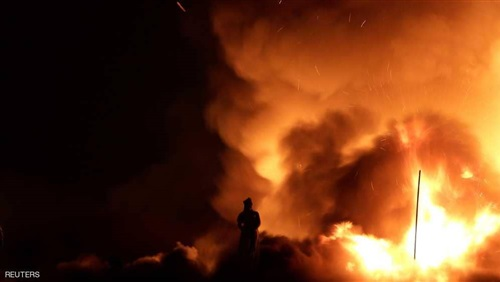

Model: ResNet18, Prediction: fire_images, Probability: 100.00%

Model: ViT_B_16, Prediction: fire_images, Probability: 99.92%

Non-Fire Image Prediction


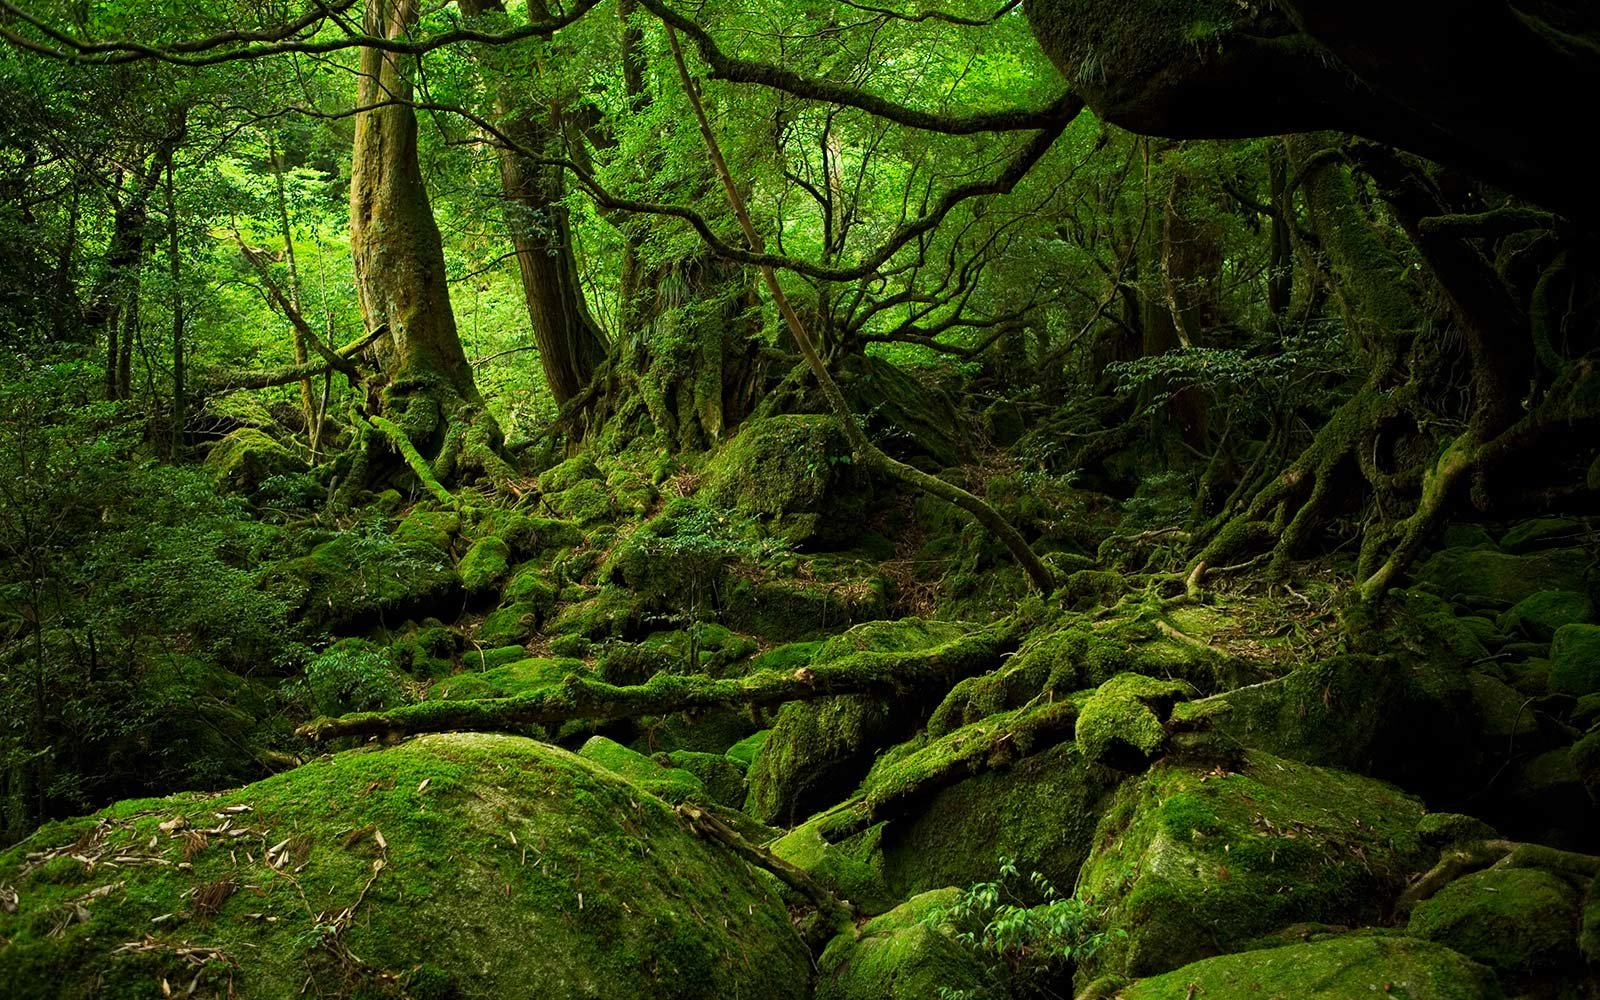

Model: ResNet18, Prediction: non_fire_images, Probability: 100.00%

Model: ViT_B_16, Prediction: non_fire_images, Probability: 99.97%



In [61]:
from PIL import Image
import os
import torch
import torch.nn.functional as F

def make_prediction(models: dict, image_path: str, transform, class_names: list, device: torch.device):
    image = Image.open(image_path).convert("RGB")
    display(image)

    input_tensor = transform(image).unsqueeze(0).to(device)

    results = {}
    with torch.no_grad():
        for model_name, model in models.items():
            model.eval().to(device)
            outputs = model(input_tensor)
            
            # Получаем вероятности и предсказания
            probabilities = F.softmax(outputs, dim=1)
            probability, predicted_class = probabilities.max(dim=1)
            results[model_name] = {
                "label": class_names[predicted_class.item()],
                "probability": probability.item()
            }
    
    for model_name, result in results.items():
        print(f"Model: {model_name}, Prediction: {result['label']}, Probability: {result['probability']*100:.2f}%\n")

    return results

models_dict = {
    "ResNet18": resnet,
    "ViT_B_16": vit
}

class_names_list = train_ds.dataset.classes if hasattr(train_ds, "dataset") else train_ds.classes

fire_image_path = os.path.join(path, "test", "fire_images", "fire.104.png")
non_fire_image_path = os.path.join(path, "test", "non_fire_images", "non_fire.101.png")

print("Fire Image Prediction")
fire_predictions = make_prediction(models_dict, fire_image_path, val_tfms, class_names_list, device)

print("Non-Fire Image Prediction")
non_fire_predictions = make_prediction(models_dict, non_fire_image_path, val_tfms, class_names_list, device)


Как видно, обе модели правильно и с большой уверенностью определили класс изображения.

# 3. Улучшение бейзлайна
## 3.a. Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)

Проведем аугментацию датасета. Добавим вращения и отражения изображений, а также сделаем изображения более контрастными, чтобы на них лучше выделялся огонь

In [125]:
import torchvision.transforms as T

baseline_tfms = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

color_jitter_tfms = T.Compose([
    T.Resize((224,224)),
    T.ColorJitter(brightness=1,contrast=2,saturation=1),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm


def run_experiment(transform, lr=1e-3, epochs=5):
    train_ds = ImageFolder(train_dir, transform=transform)
    val_ds = ImageFolder(val_dir, transform=val_tfms)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.to(device)

    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    best_acc = 0.0
    for ep in range(epochs):
        model.train()
        for x, y in tqdm(train_loader, leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()
        model.eval()
        all_pred, all_true = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                logits = model(x)
                all_pred.extend(logits.argmax(1).cpu().numpy())
                all_true.extend(y.numpy())
        acc = accuracy_score(all_true, all_pred)
        best_acc = max(best_acc, acc)
    return best_acc


configs = [
    ("baseline", baseline_tfms, 1e-3),
    ("color_jitter", color_jitter_tfms, 1e-3),
]

results_exp = {}
for name, tfm, lr in configs:
    acc = run_experiment(tfm, lr=lr, epochs=5)
    results_exp[name] = acc

print("\nРезультаты (val Accuracy):", results_exp)


Результаты (val Accuracy): {'baseline': 0.9933333333333333, 'color_jitter': 0.94}


Видно, что бейзлайн с поворотами справляется лучше

Применим его к train выборке

In [127]:
train_ds_imp    = ImageFolder(train_dir, transform=baseline_tfms)
train_loader_imp= DataLoader(train_ds_imp, batch_size=32, shuffle=True,  num_workers=2)
val_ds          = ImageFolder(val_dir,   transform=val_tfms)
val_loader      = DataLoader(val_ds,       batch_size=32, shuffle=False, num_workers=2)
test_ds         = ImageFolder(test_dir,  transform=val_tfms)
test_loader     = DataLoader(test_ds,      batch_size=32, shuffle=False, num_workers=2)

Перезапустим процесс обучения

In [ ]:
improved_models = {}
for name, constructor, weights in [
    ("ResNet18",    resnet18,    ResNet18_Weights.IMAGENET1K_V1),
    ("ViT_B_16", vit_b_16, ViT_B_16_Weights.IMAGENET1K_V1),
]:
    print(f"\n=== Training improved {name} ===")
    model = constructor(weights=weights)
    if name == "ResNet18":
        model.fc = nn.Linear(model.fc.in_features, 2)
    else:
        model.heads.head = nn.Linear(model.heads.head.in_features, 2)
    improved_models[name] = train_model(
        model,
        train_loader_imp,
        val_loader,
        lr=1e-4,
        epochs=10
    )


=== Training improved ResNet18 ===


Epoch 1/10 — Train Loss: 0.1473  Val Acc: 0.9800, Precision: 0.9722, Recall: 0.9459, F1: 0.9589


Epoch 2/10 — Train Loss: 0.0479  Val Acc: 0.9867, Precision: 0.9487, Recall: 1.0000, F1: 0.9737


Epoch 3/10 — Train Loss: 0.0333  Val Acc: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 4/10 — Train Loss: 0.0206  Val Acc: 0.9867, Precision: 1.0000, Recall: 0.9459, F1: 0.9722


Epoch 5/10 — Train Loss: 0.0197  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 6/10 — Train Loss: 0.0179  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 7/10 — Train Loss: 0.0117  Val Acc: 0.9867, Precision: 0.9487, Recall: 1.0000, F1: 0.9737


Epoch 8/10 — Train Loss: 0.0077  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867


Epoch 9/10 — Train Loss: 0.0108  Val Acc: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 10/10 — Train Loss: 0.0061  Val Acc: 0.9933, Precision: 0.9737, Recall: 1.0000, F1: 0.9867

=== Training improved ViT_B_16 ===


Epoch 1/10 — Train Loss: 0.1395  Val Acc: 0.9533, Precision: 1.0000, Recall: 0.8108, F1: 0.8955


Epoch 2/10 — Train Loss: 0.0475  Val Acc: 0.9867, Precision: 1.0000, Recall: 0.9459, F1: 0.9722


Epoch 3/10 — Train Loss: 0.0198  Val Acc: 0.9867, Precision: 1.0000, Recall: 0.9459, F1: 0.9722


Epoch 4/10 — Train Loss: 0.0107  Val Acc: 0.9867, Precision: 1.0000, Recall: 0.9459, F1: 0.9722


Epoch 5/10 — Train Loss: 0.0090  Val Acc: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Epoch 6/10 — Train Loss: 0.0048  Val Acc: 0.9933, Precision: 1.0000, Recall: 0.9730, F1: 0.9863


Epoch 7/10 — Train Loss: 0.0035  Val Acc: 0.9867, Precision: 1.0000, Recall: 0.9459, F1: 0.9722


Epoch 8/10 — Train Loss: 0.0017  Val Acc: 0.9933, Precision: 1.0000, Recall: 0.9730, F1: 0.9863


Epoch 9/10 — Train Loss: 0.0092  Val Acc: 0.9667, Precision: 1.0000, Recall: 0.8649, F1: 0.9275


Epoch 10/10 — Train Loss: 0.0449  Val Acc: 0.8800, Precision: 1.0000, Recall: 0.5135, F1: 0.6786


In [129]:
impr_results = {}
for name, model in improved_models.items():
    acc, prec, rec, f1 = evaluate_model(model, test_loader)
    impr_results[name] = (acc, prec, rec, f1)
    print(f"{name} "
          f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, "
          f"Recall: {rec:.4f}, F1: {f1:.4f}")

ResNet18 Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
ViT_B_16 Accuracy: 0.9139, Precision: 1.0000, Recall: 0.6486, F1: 0.7869


Вследствие аугментации данных точность ViT уменьшилась. Перевернутый огонь не помогает в обучении

# 4.	Имплементация алгоритма машинного обучения

Реализация сверточной сети с использованием Torch

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pandas as pd
from tqdm import tqdm

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64 * 28 * 28, num_classes)
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)

Попробуем обучить модель на 5 эпохах

In [47]:
train_ds_base = ImageFolder(train_dir, transform=baseline_tfms)
val_ds_base   = ImageFolder(val_dir,   transform=baseline_tfms)
test_ds       = ImageFolder(test_dir,  transform=baseline_tfms)

train_loader_base = DataLoader(train_ds_base, batch_size=32, shuffle=True,  num_workers=2)
val_loader_base   = DataLoader(val_ds_base,   batch_size=32, shuffle=False, num_workers=2)
test_loader       = DataLoader(test_ds,        batch_size=32, shuffle=False, num_workers=2)

model_base = SimpleCNN(num_classes=2).to(device)
optimizer = optim.Adam(model_base.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    loss = train_epoch(model_base, train_loader_base, optimizer, criterion)
acc_base, prec_base, rec_base, f1_base = evaluate_model(model_base, test_loader)

Запустим для улучшенного бейзлайна на 10 эпохах

In [49]:
train_ds_imp = ImageFolder(train_dir, transform=cj_tfms)
val_ds_imp   = ImageFolder(val_dir,   transform=cj_tfms)

train_loader_imp = DataLoader(train_ds_imp, batch_size=32, shuffle=True,  num_workers=2)
val_loader_imp   = DataLoader(val_ds_imp,   batch_size=32, shuffle=False, num_workers=2)

model_imp = SimpleCNN(num_classes=2).to(device)
optimizer_imp = optim.Adam(model_imp.parameters(), lr=1e-4)

for epoch in range(10):
    loss = train_epoch(model_imp, train_loader_imp, optimizer_imp, criterion)
acc_imp, prec_imp, rec_imp, f1_imp = evaluate(model_imp, test_loader)

In [75]:
from tabulate import tabulate

table = [
    ["Модель", "Accuracy", "Precision", "Recall", "F1"],
    ["Базовый Baseline", f"{acc_base:.3f}", f"{prec_base:.3f}", f"{rec_base:.3f}", f"{f1_base:.3f}"],
    ["Улучшенный Baseline", f"{acc_imp:.3f}", f"{prec_imp:.3f}", f"{rec_imp:.3f}", f"{f1_imp:.3f}"]
]

print(tabulate(table, headers="firstrow", tablefmt="grid"))

+---------------------+------------+-------------+----------+-------+
| Модель              |   Accuracy |   Precision |   Recall |    F1 |
+=====================+============+=============+==========+=======+
| Базовый Baseline    |      0.934 |       0.8   |    0.973 | 0.878 |
+---------------------+------------+-------------+----------+-------+
| Улучшенный Baseline |      0.861 |       0.638 |    1     | 0.779 |
+---------------------+------------+-------------+----------+-------+


Самописные модели уступают встроенным. При этом интересно, что на улучшенном Baseline результаты получаются хуже

Реализуем упрощенный ViT

In [52]:
class SimpleViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, emb_dim=128, depth=6, n_heads=8, mlp_ratio=4, num_classes=2):
        super(SimpleViT, self).__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(3, emb_dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads,
                                                   dim_feedforward=emb_dim * mlp_ratio, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Linear(emb_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1,2)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed

        x = self.transformer(x)

        cls_out = x[:,0]
        return self.head(cls_out)


Базовый бейзлайн

In [55]:
vit_base = SimpleViT()
res_base_metrics = train_model(vit_base, train_loader_base, val_loader, lr=1e-3, epochs=5)

Улучшенный бейзлайн

In [56]:
vit_imp = SimpleViT()
res_imp_metrics = train_model(vit_imp, train_loader_imp, val_loader, lr=1e-4, epochs=10)

In [76]:
models = ['SimpleViT']
baseline_vals = res_base_metrics
improved_vals = res_imp_metrics

table = [
    ["Модель", "Accuracy", "Precision", "Recall", "F1"],
    ["Базовый Baseline", f"{baseline_vals[0]:.3f}", f"{baseline_vals[1]:.3f}", f"{baseline_vals[2]:.3f}", f"{baseline_vals[3]:.3f}"],
    ["Улучшенный Baseline", f"{improved_vals[0]:.3f}", f"{improved_vals[1]:.3f}", f"{improved_vals[2]:.3f}", f"{improved_vals[3]:.3f}"]
]

print(tabulate(table, headers="firstrow", tablefmt="grid"))

+---------------------+------------+-------------+----------+-------+
| Модель              |   Accuracy |   Precision |   Recall |    F1 |
+=====================+============+=============+==========+=======+
| Базовый Baseline    |      0.934 |       0.814 |    0.946 | 0.875 |
+---------------------+------------+-------------+----------+-------+
| Улучшенный Baseline |      0.947 |       0.892 |    0.892 | 0.892 |
+---------------------+------------+-------------+----------+-------+


Здесь самописная модель также уступает готовой реализации, однако модель, обученная на улучшенном бейзлайне, отрабатывает лучше

In [6]:
from tabulate import tabulate


table = [
    ["Модель", "Accuracy", "Precision", "Recall", "F1"],
    ["ResNet18 Базовый Baseline", 1, 1, 1, 1],
    ["ResNet18 Улучшенный Baseline", 0.9933, 0.9737, 1, 0.9867],
    ["ViT_B_16 Базовый Baseline", 0.993, 1, 0.973, 0.986],
    ["ViT_B_16 Улучшенный Baseline", 0.88, 1, 0.5135, 0.6786],
    ["Simple CNN Базовый Baseline", 0.934, 0.8, 0.973, 0.878],
    ["Simple CNN Улучшенный Baseline", 0.861, 0.638, 1, 0.779],
    ["Simple ViT Базовый Baseline", 0.934, 0.814, 0.946, 0.875],
    ["Simplte ViT Улучшенный Baseline", 0.947, 0.892, 0.892, 0.892]
]

print(tabulate(table, headers="firstrow", tablefmt="grid"))

+---------------------------------+------------+-------------+----------+--------+
| Модель                          |   Accuracy |   Precision |   Recall |     F1 |
+=================================+============+=============+==========+========+
| ResNet18 Базовый Baseline       |     1      |      1      |   1      | 1      |
+---------------------------------+------------+-------------+----------+--------+
| ResNet18 Улучшенный Baseline    |     0.9933 |      0.9737 |   1      | 0.9867 |
+---------------------------------+------------+-------------+----------+--------+
| ViT_B_16 Базовый Baseline       |     0.993  |      1      |   0.973  | 0.986  |
+---------------------------------+------------+-------------+----------+--------+
| ViT_B_16 Улучшенный Baseline    |     0.88   |      1      |   0.5135 | 0.6786 |
+---------------------------------+------------+-------------+----------+--------+
| Simple CNN Базовый Baseline     |     0.934  |      0.8    |   0.973  | 0.878  |
+---